In this notebook, we explore the maximum wind speed the UAV can counteract at different max velocities.

In [1]:
from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from multirotor.coords import body_to_inertial, inertial_to_body, direction_cosine_matrix, euler_to_angular_rate
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_pidcontroller import (
    get_controller, make_disturbance_fn,
    apply_params as apply_params_pid, get_study as get_study_pid
)
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent

In [2]:
best_agent = PIDAgent()
best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000}
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params, speed, wp):
    references = []
    errors = []
    speeds = []
    velocities = []
    env = env_selector.get_env("sliding", params, wind_ranges, wp, start_alt=wp[0][2], has_turbulence=False)
    params = env.base_env.ctrl.get_params()
    params['ctrl_p']['max_velocity'] = speed
    params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
    
    env.base_env.ctrl.set_params(**params)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
        speeds.append([env.base_env.vehicle.speeds])
        velocities.append(env.base_env.vehicle.inertial_velocity)

    log.done_logging()
    return log, info, np.array(errors), np.array(speeds), np.array(velocities), env.base_env.vehicle.all_forces, env.base_env.vehicle.all_torques, env.base_env.wind_forces, env.base_env.vehicle.all_dxdt

In [3]:
# The UAV can compensate for that wind at its speed if it progresses towards the negative direction
def can_compensate(log):
    return not np.all(np.diff(log.y) > 0)

In [4]:
# min_speeds = []
# for wind in tqdm(winds):
#     wind_range = [(0,0),(wind,wind),(0,0)]

#     prev_speed = possible_speeds[0]
#     for speed in possible_speeds:
#         log, info, _, _, _ = run_trajectory(env_selector, wind_range, best_agent, best_params, speed, south_np)
#         if not can_compensate(log):
#             min_speeds.append([wind, prev_speed])
#             break
#         prev_speed = speed

In [5]:
# min_speeds

In [6]:
# df = pd.DataFrame(min_speeds, columns=['Wind Speed', 'Vehicle Speed'])
# df.to_csv('./data/min_speeds.csv')

# # Create the bar plot using Seaborn
# sns.set(style="whitegrid")  # Set the style
# plt.figure(figsize=(10, 6))  # Set the figure size

# # Create the bar plot
# plot = sns.barplot(x='Wind Speed', y='Vehicle Speed', data=df, color='purple', alpha=0.5)

# # Set labels and title
# plt.xlabel('Wind Speed (m/s)')
# plt.ylabel('Min Desired Speed to Compensate (m/s)')
# plt.title('Wind Compensation')

# # Show the plot
# plt.show()

In [7]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [8]:
south_np = np.array([[0,-10,0]])

In [9]:
# winds = [7,8,9,10,11,12]
# possible_speeds = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

# min_speeds = []
# for wind in tqdm(winds):
#     wind_range = [(0,0),(wind,wind),(0,0)]

#     prev_speed = possible_speeds[-1]
#     for speed in reversed(possible_speeds):
#         log, info, _, _ = run_trajectory(env_selector, wind_range, best_agent, best_params, speed, south_np)
#         if not info['reached']:
#             min_speeds.append([wind, prev_speed])
#             break
#         prev_speed = speed

In [10]:
# winds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# possible_speeds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# south_np = np.array([[0,-250,50]])
# results = []
# # square_np = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

# min_speeds = []
# for wind in tqdm(winds):
#     wind_range = [(wind,wind),(0,0),(0,0)]
    
#     for speed in reversed(possible_speeds):
#         log, info, _, _, velocities, forces, torques, wind_f = run_trajectory(env_selector, wind_range, best_agent, best_params, speed, south_np)
        
#         results.append([log, speed, wind])

In [11]:
# def percent_toc(log):
#     return np.count_nonzero(np.abs(log.x) > 2) / len(log.x)

In [12]:
# tocs = []
# for r in results:
#     tocs.append([percent_toc(r[0]), r[1], r[2]])

In [13]:
# tocs = np.array(tocs)

# plt.scatter(tocs[:,1], tocs[:,2], c=tocs[:,0])

In [14]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot for the points
# scatter = ax.scatter(tocs[:, 1], tocs[:, 2], tocs[:, 0]*100, c=tocs[:, 0], cmap='viridis')

# # Adding a plane at 0.05 height in red
# x_plane = np.linspace(min(tocs[:, 1]), max(tocs[:, 1]), 100)
# y_plane = np.linspace(min(tocs[:, 2]), max(tocs[:, 2]), 100)
# x_plane, y_plane = np.meshgrid(x_plane, y_plane)
# z_plane = np.full_like(x_plane, 0.05)

# ax.plot_surface(x_plane, y_plane, z_plane, color='red', alpha=0.5, label='5%')

# # Setting labels
# ax.set_xlabel('Max Vehicle Speed')
# ax.set_ylabel('Perpendicular Wind Speed')
# ax.set_zlabel('Percent Time Outside 2m Corridor')

# # Adding a color bar
# # cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
# # cbar.set_label('Color')
# plt.title("South Waypoint Perpendicular Wind Time Outside Corridor")
# ax.view_init(10,-10)
# plt.legend()

# plt.show()

In [15]:
# idx = 89
# plt.plot(results[idx][0].velocity)
# print(results[idx][2], results[idx][1])

In [16]:
# plt.plot(results[idx][0].x, results[idx][0].y)

In [17]:
# plt.plot(results[idx][0].position[:,0])

In [18]:
# df = pd.DataFrame(min_speeds, columns=['Wind Speed', 'Vehicle Speed'])
# # df['Vehicle Speed'] *= -1
# df.to_csv('./data/max_speeds_wind.csv')

# # Create the bar plot using Seaborn
# sns.set(style="whitegrid")  # Set the style
# plt.figure(figsize=(10, 6))  # Set the figure size

# # Create the bar plot
# plot = sns.barplot(x='Wind Speed', y='Vehicle Speed', data=df, color='purple', alpha=0.5)

# # Set labels and title
# plt.xlabel('Wind Speed (m/s)')
# plt.ylabel('Max Vehicle Speed (m/s)')
# plt.title('Max Achievable Speeds Under Wind')

# # Show the plot
# plt.show()

In [19]:
# def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params, speed, wp):
#     references = []
#     errors = []
#     speeds = []
#     velocities = []
#     env = env_selector.get_env("sliding", params, wind_ranges, wp, start_alt=50, has_turbulence=False)
#     params = env.base_env.ctrl.get_params()
#     # params['ctrl_p']['max_velocity'] = speed
#     params['ctrl_v']['max_tilt'] = np.deg2rad(22.5)
#     # params['ctrl_v']['k_i'] = 0
#     # params['ctrl_v']['k_d'] = 0
#     # params['ctrl_v']['k_p'] = 1
#     # print(params['ctrl_v']['k_p'])
    
    
#     env.base_env.ctrl.set_params(**params)
#     done = False
#     state = np.array(env.reset(), dtype=np.float32)
#     log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
#                       other_vars=('reward',))
#     while not done:
#         action = agent.predict(state, deterministic=True)[0]
#         state, reward, done, info = env.step(action)
#         state = np.array(state, dtype=np.float32)
#         log.log(reward=reward)
#         errors.append([env.base_env.ctrl.ctrl_v.err_p, env.base_env.ctrl.ctrl_v.err_i])
#         speeds.append([env.base_env.vehicle.speeds])
#         velocities.append(env.base_env.vehicle.inertial_velocity)
#         if log.t[-1]*100 > 5000:
#             done = True

#     log.done_logging()
#     return log, info, np.array(errors), np.array(speeds), np.array(velocities), env.base_env.vehicle.all_forces, env.base_env.vehicle.all_torques, env.base_env.wind_forces

In [20]:
winds = [0]
possible_speeds = [15]
south_np = np.array([[0,-250,30]])

east_np = np.array([[800,0,50]])

square_np = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

min_speeds = []
for wind in tqdm(winds):
    # wind_range = [(wind,wind),(0,0),(0,0)]
    wind_range = [(0,0),(wind,wind),(0,0)]
    

    prev_speed = possible_speeds[-1]
    for speed in reversed(possible_speeds):
        log, info, err, speeds, velocities, forces, torques, wind_f, dxdts = run_trajectory(env_selector, wind_range, best_agent, best_params, speed, south_np)
        
        min_speeds.append([wind, max(velocities[:,1])])
        prev_speed = speed

  0%|          | 0/1 [00:00<?, ?it/s]

Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault
Has fault


(0.0, 35.0)

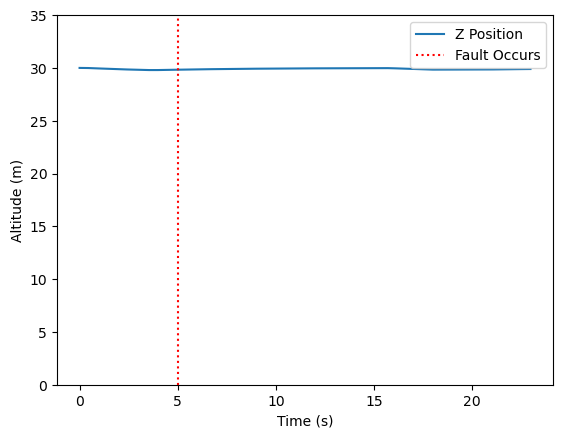

In [21]:
plt.plot(np.arange(len(log.z))/100, log.z, label='Z Position')
plt.axvline(5, linestyle=':', color='red', label='Fault Occurs')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.ylim(0, 35)

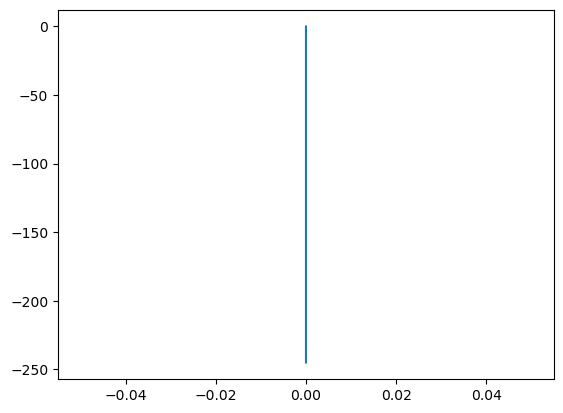

In [22]:
plt.plot(log.x, log.y)

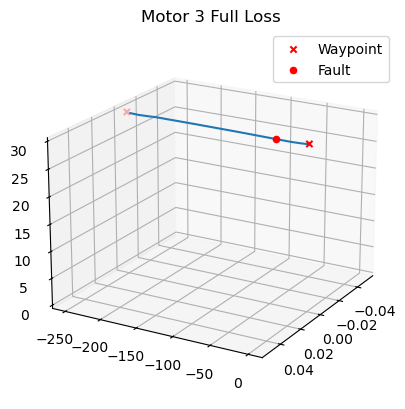

In [23]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(log.x, log.y, log.z)
ax.scatter([0,0], [0,-250], [30,30], marker='x', color='red', label='Waypoint')
ax.scatter(log.x[500], log.y[500], log.z[500], marker='o', color='red', label='Fault')


ax.set_zlim(0, 30)
ax.view_init(20,30)
ax.set_title("Motor 3 Full Loss")
plt.legend()

(0.0, 550.0)

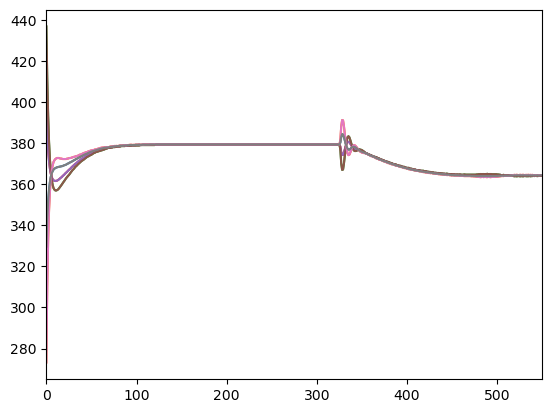

In [24]:
plt.plot(speeds.squeeze())
plt.xlim(0, 550)

In [25]:
# pd.DataFrame(speeds.squeeze()).to_csv('./data/python_speeds.csv')

In [26]:
xlimit = (0, 800)

### Position

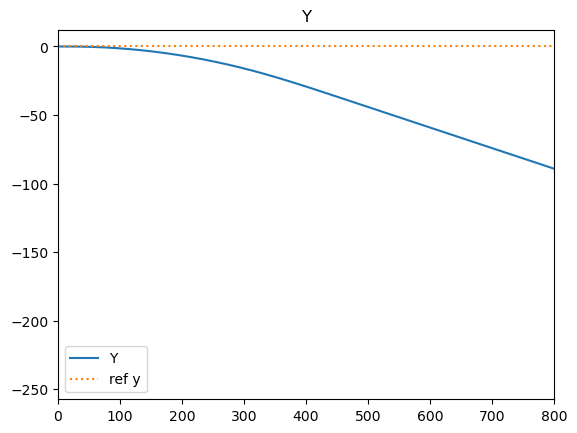

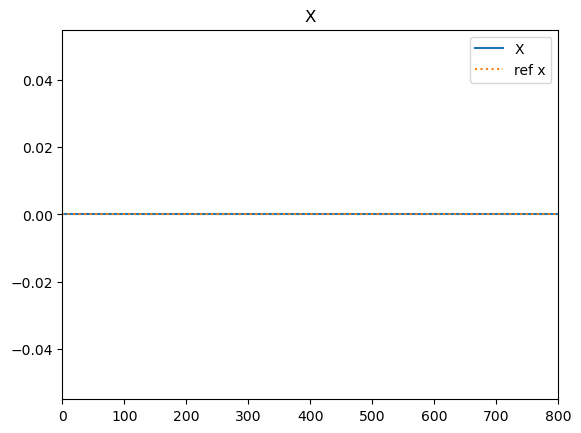

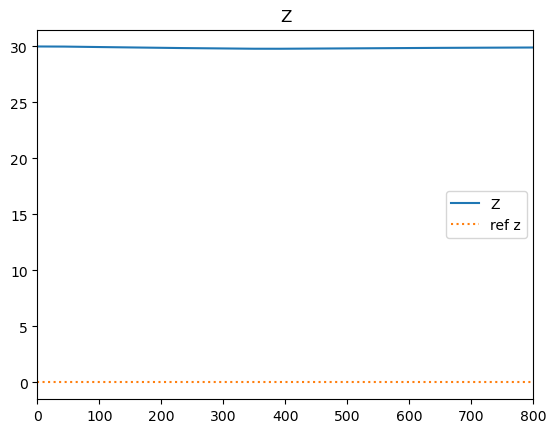

In [27]:
plt.plot(log.y, label='Y')
plt.plot(log.target.position[:,1], linestyle=':', label='ref y')
plt.xlim(xlimit)
plt.legend()
plt.title("Y")
plt.show()

plt.plot(log.x, label='X')
plt.plot(log.target.position[:,0], linestyle=':', label='ref x')
plt.xlim(xlimit)
plt.legend()
plt.title("X")
plt.show()

plt.plot(log.z, label='Z')
plt.plot(log.target.position[:,2], linestyle=':', label='ref z')
plt.xlim(xlimit)
plt.legend()
plt.title("Z")
plt.show()

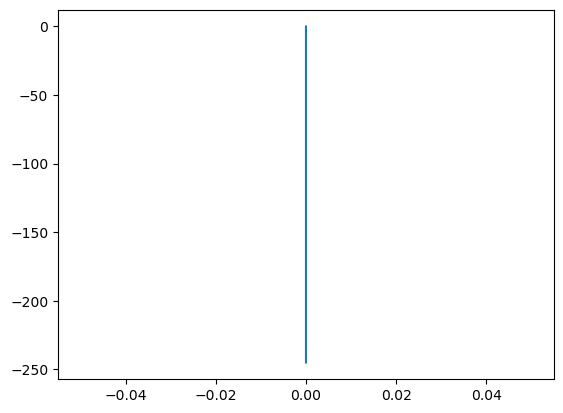

In [28]:
plt.plot(log.x, log.y)

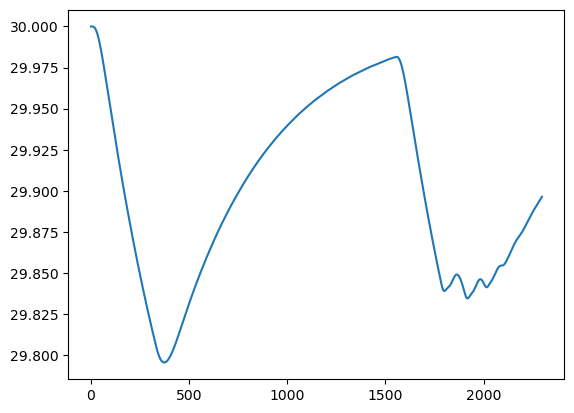

In [29]:
plt.plot(log.z)

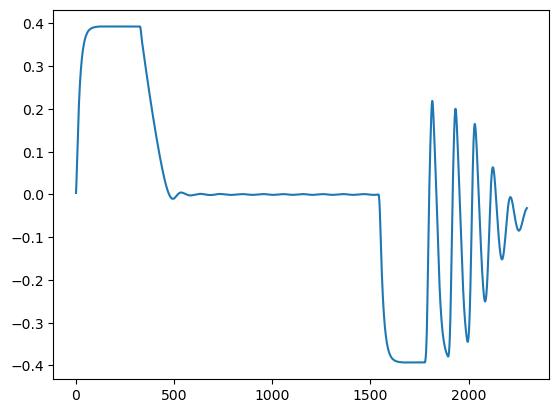

In [30]:
plt.plot(log.roll)

### Velocity

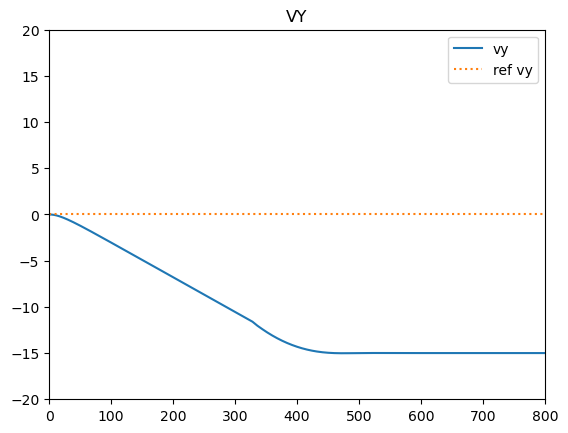

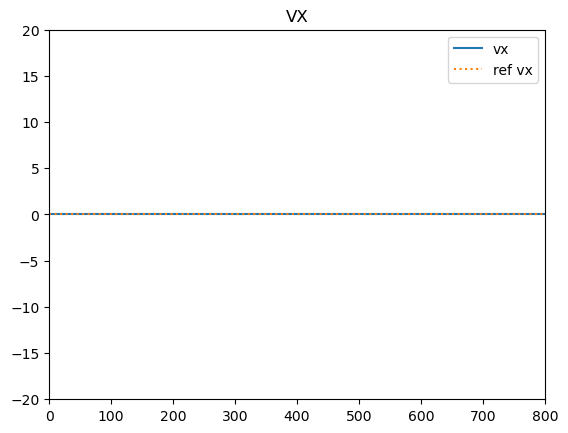

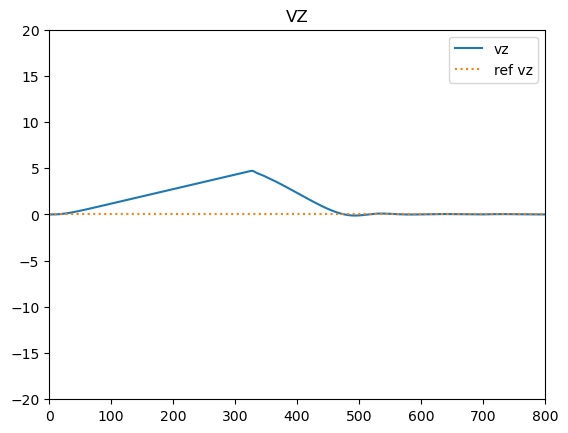

In [31]:
plt.plot(log.velocity[:,1], label='vy')
plt.plot(log.target.velocity[:,1], linestyle=':', label='ref vy')
plt.xlim(xlimit)
plt.ylim(-20, 20)
plt.legend()
plt.title("VY")
plt.show()

plt.plot(log.velocity[:,0], label='vx')
plt.plot(log.target.velocity[:,0], linestyle=':', label='ref vx')
plt.ylim(-20, 20)
plt.xlim(xlimit)
plt.legend()
plt.title("VX")
plt.show()

plt.plot(log.velocity[:,2], label='vz')
plt.plot(log.target.velocity[:,2], linestyle=':', label='ref vz')
plt.ylim(-20, 20)
plt.xlim(xlimit)
plt.legend()
plt.title("VZ")
plt.show()

### Angle

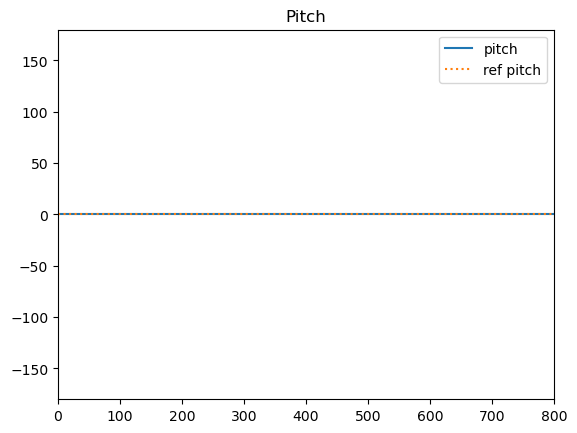

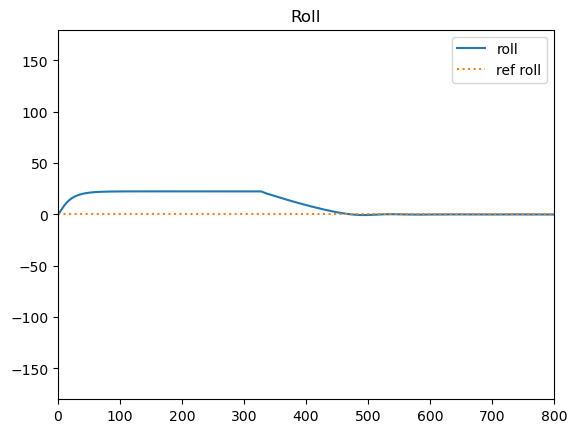

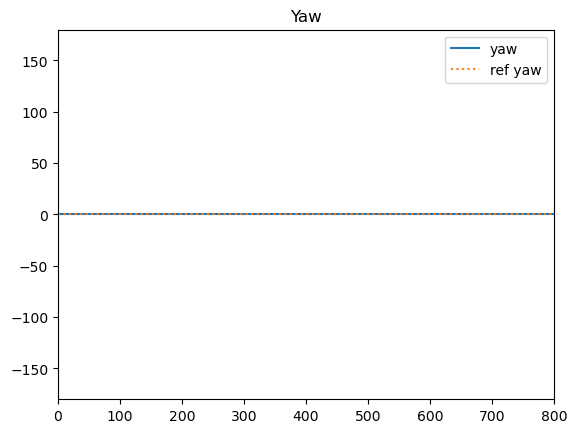

In [32]:
plt.plot(np.rad2deg(log.orientation[:,1]), label='pitch')
plt.plot(np.rad2deg(log.target.orientation[:,1]), linestyle=':', label='ref pitch')
plt.xlim(xlimit)
plt.ylim(-180,180)
plt.legend()
plt.title("Pitch")
plt.show()

plt.plot(np.rad2deg(log.orientation[:,0]), label='roll')
plt.plot(np.rad2deg(log.target.orientation[:,0]), linestyle=':', label='ref roll')
plt.xlim(xlimit)
plt.ylim(-180,180)
plt.legend()
plt.title("Roll")
plt.show()

plt.plot(np.rad2deg(log.orientation[:,2]), label='yaw')
plt.plot(np.rad2deg(log.target.orientation[:,2]), linestyle=':', label='ref yaw')
plt.xlim(xlimit)
plt.ylim(-180,180)
plt.legend()
plt.title("Yaw")
plt.show()

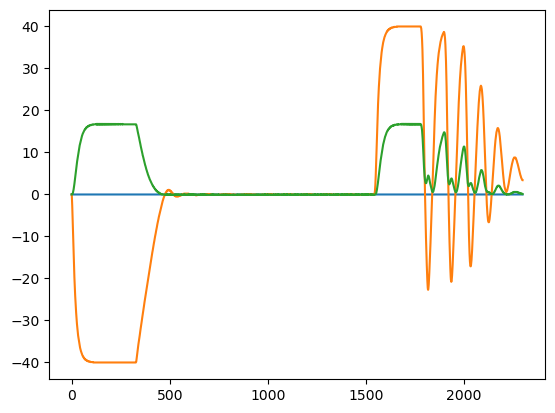

In [33]:
plt.plot(forces)

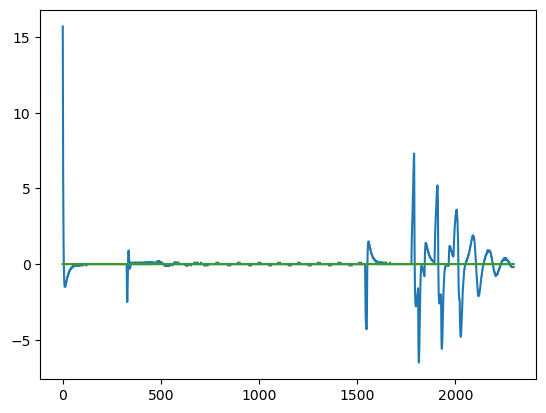

In [34]:
plt.plot(torques)

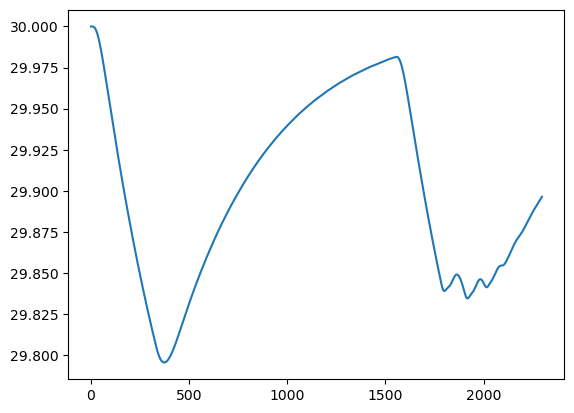

In [35]:
# plt.plot(log.x, log.y)
plt.plot(log.z)

### Rate

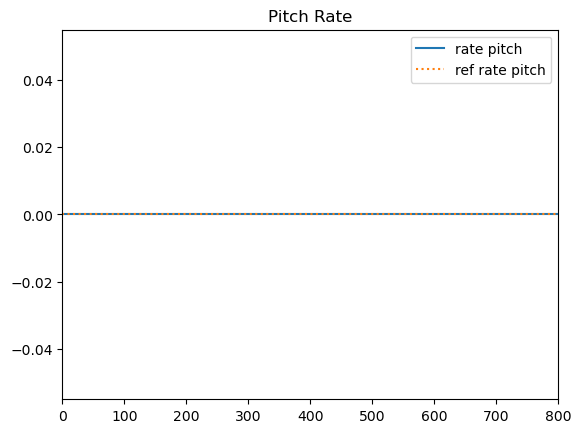

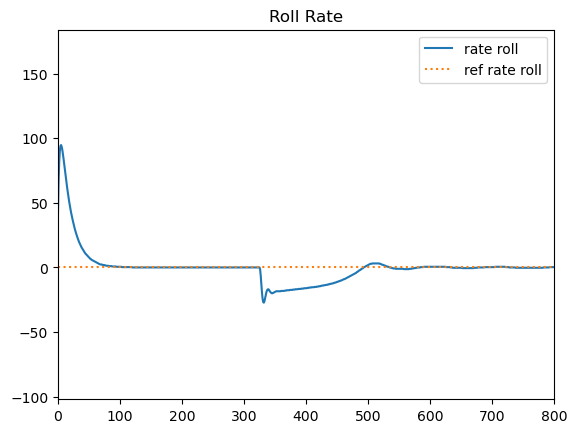

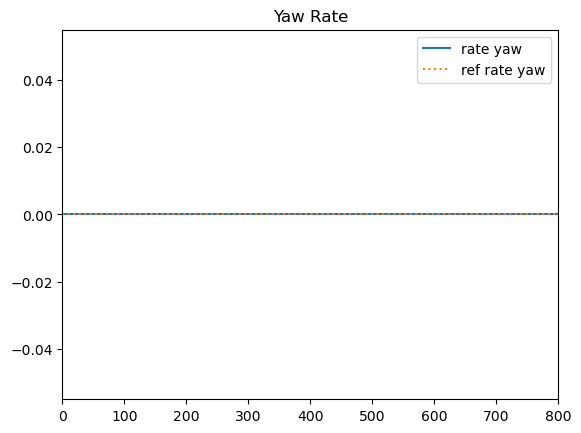

In [36]:
plt.plot(np.rad2deg(log.angular_rate[:,1]), label='rate pitch')
plt.plot(np.rad2deg(log.target.rate[:,1]), linestyle=':', label='ref rate pitch')
plt.xlim(xlimit)
plt.legend()
plt.title("Pitch Rate")
plt.show()

plt.plot(np.rad2deg(log.angular_rate[:,0]), label='rate roll')
plt.plot(np.rad2deg(log.target.rate[:,0]), linestyle=':', label='ref rate roll')
plt.xlim(xlimit)
plt.legend()
plt.title("Roll Rate")
plt.show()

plt.plot(np.rad2deg(log.angular_rate[:,2]), label='rate yaw')
plt.plot(np.rad2deg(log.target.rate[:,2]), linestyle=':', label='ref rate yaw')
plt.xlim(xlimit)
plt.legend()
plt.title("Yaw Rate")
plt.show()

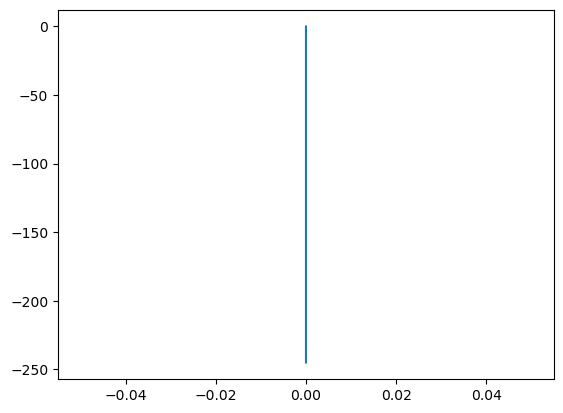

In [37]:
plt.plot(log.x, log.y)

In [38]:
# np.savetxt('./data/crash_logs.csv', np.concatenate([np.array(forces), np.array(torques)], axis=1), fmt='%f', delimiter=',')